# Preprocess

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import math
from datetime import datetime
from tqdm import tqdm

In [2]:
GENERATED_DATA = "/storage/jitbitan/outputs/cam16_tiles/"
HDF5_FILE = GENERATED_DATA + "all_wsi_tile256_poiNormal0.2_poiTumor0.6_level3.hdf5"
CHECKPOINT = "/storage/jitbitan/outputs/inception_resnetv2_cam16.pt"

In [3]:
with h5py.File(HDF5_FILE, "r") as f:
    normal_tiles = 0
    normal_slides = 0
    tumor_tiles = 0
    tumor_slides = 0

    for key in f.keys():
        x = f[key].shape[0]
        if key.startswith("nor"):
            normal_tiles += x
            normal_slides += 1
        else:
            tumor_tiles += x
            tumor_slides += 1

    print(f"normal:\tslide count: {normal_slides} \n\ttile  count: {normal_tiles}\n")
    print(f"tumor:\tslide count: {tumor_slides} \n\ttile  count: {tumor_tiles}")

normal:	slide count: 160 
	tile  count: 116147

tumor:	slide count: 73 
	tile  count: 15767


In [4]:
class TissueDataset:
    """Data set for preprocessed WSIs of the CAMELYON16 and CAMELYON17 data set."""

    def __init__(self, path, p=0.5, first=True):
        self.h5_file = path
        self.h5 = h5py.File(path, "r", libver="latest", swmr=True)
        self.perc = p
        self.first = first
        self.dataset_names = list(self.h5.keys())
        self.neg = [i for i in self.dataset_names if "ormal" in i]
        self.pos = [i for i in self.dataset_names if "umor" in i]
        self.dims = self.h5[self.neg[0]][0].shape

    def __get_tiles_from_path(self, dataset_names, max_wsis, number_tiles):
        tiles = np.ndarray((number_tiles, 256, 256, 3))
        for i in range(number_tiles):
            file_idx = np.random.randint(0, max_wsis)
            dset = self.h5[dataset_names[file_idx]]
            # dset = np.transpose(dset, (0,3,1,2))
            len_ds = len(dset)
            max_tiles = math.ceil(len_ds * self.perc)
            if self.first:
                rnd_idx = np.random.randint(0, max_tiles)
            else:
                rnd_idx = np.random.randint(len_ds - max_tiles, len_ds)
            # crop random 256x256
            if self.dims[1] > 256:
                rand_height = np.random.randint(0, self.dims[0] - 256)
                rand_width = np.random.randint(0, self.dims[1] - 256)
            else:
                rand_height = 0
                rand_width = 0
            tiles[i] = dset[
                rnd_idx, rand_height : rand_height + 256, rand_width : rand_width + 256
            ]
        tiles = tiles / 255.0
        return tiles

    def __get_random_positive_tiles(self, number_tiles):
        return self.__get_tiles_from_path(
            self.pos, len(self.pos), number_tiles
        ), np.ones((number_tiles))

    def __get_random_negative_tiles(self, number_tiles):
        return self.__get_tiles_from_path(
            self.neg, len(self.neg), number_tiles
        ), np.zeros((number_tiles))

    def batch_generator(
        self,
        num_neg=10,
        num_pos=10,
        data_augm=False,
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
    ):
        while True:
            x, y = self.get_batch(num_neg, num_pos, data_augm)
            for i in [0, 1, 2]:
                x[:, :, :, i] = (x[:, :, :, i] - mean[i]) / std[i]
            yield x, y

    def get_batch(
        self,
        num_neg=10,
        num_pos=10,
        data_augm=False,
        mean=[0, 0, 0],
        std=[1, 1, 1],
    ):
        x_p, y_p = self.__get_random_positive_tiles(num_pos)
        x_n, y_n = self.__get_random_negative_tiles(num_neg)
        x = np.concatenate((x_p, x_n), axis=0)
        y = np.concatenate((y_p, y_n), axis=0)
        if data_augm:
            # some data augmentation mirroring / rotation
            if np.random.randint(0, 2):
                x = np.flip(x, axis=1)
            if np.random.randint(0, 2):
                x = np.flip(x, axis=2)
            x = np.rot90(m=x, k=np.random.randint(0, 4), axes=(1, 2))

        for i in range(3):
            x[:, :, :, i] = (x[:, :, :, i] - mean[i]) / std[i]

        # randomly arrange in order
        p = np.random.permutation(len(y))
        return np.transpose(x[p], (0, 3, 1, 2)), y[p]

In [5]:
def learning_session(
    epochs=5,
    train_batches=10,
    val_batches=5,
    batch_negative=10,
    batch_positive=10,
):
    train_data = TissueDataset(path=HDF5_FILE, p=0.5, first=True)
    val_data = TissueDataset(path=HDF5_FILE, p=0.5, first=False)

    # mean_pixel = np.full((3), 0.0)
    # std_pixel = np.full((3), 1.0)

    # mean_channel = []
    # std_channel = []

    # with h5py.File(HDF5_FILE, "r") as f:
    #     all_keys = f.keys()
    #     for key in all_keys:
    #         data = f[key][:]
    #         mean_channel.append(np.mean(data, axis=(0, 1, 2)))
    #         std_channel.append(np.std(data, axis=(0, 1, 2)))

    # mean_channel_pixel = np.stack(mean_channel)
    # std_channel_pixel = np.stack(std_channel)

    # mean_pixel = np.mean(mean_channel_pixel, axis=0)
    # std_pixel = np.std(std_channel_pixel, axis=0)

    mean_pixel = np.array([189.83239041, 157.00127921, 188.64640922])
    std_pixel = np.array([10.63437092, 13.99272164, 12.21288545])

    train_loader = train_data.batch_generator(
        num_neg=20,
        num_pos=20,
        data_augm=True,
        mean=mean_pixel,
        std=std_pixel,
    )
    val_loader = val_data.batch_generator(
        num_neg=20,
        num_pos=20,
        data_augm=True,
        mean=mean_pixel,
        std=std_pixel,
    )

    from inception_resnet_v2 import InceptionResNetV2

    if torch.cuda.is_available():
        inception = InceptionResNetV2().cuda()
    else:
        inception = InceptionResNetV2()

    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(inception.parameters(), lr=0.00001)

    try:
        inception.load_state_dict(torch.load(CHECKPOINT))
    except:
        pass

    e = epochs
    n_train = train_batches * (batch_negative + batch_positive)
    n_val = val_batches * (batch_negative + batch_positive)

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    for i in range(e):
        t1 = datetime.now()

        train_corr = 0
        val_corr = 0

        j = 0
        for X_train, y_train in train_loader:
            if j == train_batches:
                break
            X_train = torch.FloatTensor(X_train).cuda()
            y_train = torch.LongTensor(y_train).cuda()
            # X_train = X_train.to("cuda")
            # y_train = y_train.to("cuda")
            y_pred = inception.forward(X_train)
            loss = criterion(y_pred, y_train)
            train_losses.append(loss.item())

            predicted = torch.max(y_pred.data, 1)[1]
            train_corr += (predicted == y_train).sum().item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            j += 1

        train_accuracy.append(train_corr * 100 / n_train)

        j = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                if j == val_batches:
                    break
                X_val = torch.FloatTensor(X_val).cuda()
                y_val = torch.LongTensor(y_val).cuda()
                # X_val = X_val.to("cuda")
                # y_val = y_val.to("cuda")
                y_pred = inception.forward(X_val)
                loss = criterion(y_pred, y_val)
                val_losses.append(loss.item())

                predicted = torch.max(y_pred.data, 1)[1]
                val_corr += (predicted == y_val).sum().item()
                j += 1
            val_accuracy.append(val_corr * 100 / n_val)

        torch.save(inception.state_dict(), CHECKPOINT)

        t2 = datetime.now()
        t = (t2 - t1).seconds

        print(
            f"epoch: {i+1}\ttrain loss: {train_losses[i]:.3f} \ttrain accuracy: {train_accuracy[i]:2.3f}%"
        )
        print(
            f"\t\tval loss:   {val_losses[i]:.3f} \tval accuracy:   {val_accuracy[i]:2.3f}%"
        )
        print(
            f"\t\tt/itr: {t}s\t\teta: {(e-i)*t/3600:.0f}hr {(((e-i)*t)%3600)/60:.0f}min\n"
        )

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, top=0.85)
    fig.suptitle("Results", fontsize=15)

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.title.set_text("train loss")
    ax1.plot(train_losses)

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.title.set_text("train accuracy")
    ax2.plot(train_accuracy)

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.title.set_text("val loss")
    ax3.plot(val_losses)

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.title.set_text("val accuracy")
    ax4.plot(val_accuracy)

    plt.show()

epoch: 1	train loss: 0.368 	train accuracy: 95.875%
		val loss:   0.350 	val accuracy:   92.300%
		t/itr: 117s		eta: 3hr 15min

epoch: 2	train loss: 0.367 	train accuracy: 95.775%
		val loss:   0.410 	val accuracy:   91.350%
		t/itr: 114s		eta: 3hr 8min

epoch: 3	train loss: 0.370 	train accuracy: 95.725%
		val loss:   0.431 	val accuracy:   91.650%
		t/itr: 111s		eta: 3hr 1min

epoch: 4	train loss: 0.345 	train accuracy: 96.175%
		val loss:   0.447 	val accuracy:   90.350%
		t/itr: 111s		eta: 3hr 59min

epoch: 5	train loss: 0.351 	train accuracy: 95.850%
		val loss:   0.347 	val accuracy:   93.300%
		t/itr: 113s		eta: 3hr 1min

epoch: 6	train loss: 0.369 	train accuracy: 96.250%
		val loss:   0.431 	val accuracy:   92.350%
		t/itr: 109s		eta: 3hr 53min

epoch: 7	train loss: 0.349 	train accuracy: 96.400%
		val loss:   0.377 	val accuracy:   93.800%
		t/itr: 113s		eta: 3hr 57min

epoch: 8	train loss: 0.400 	train accuracy: 95.650%
		val loss:   0.416 	val accuracy:   92.850%
		t/itr: 1

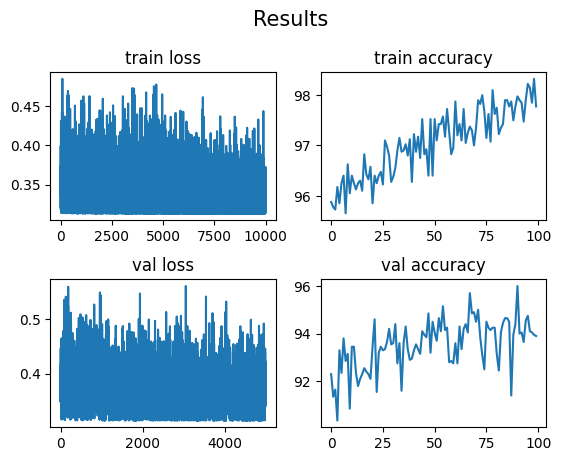

In [6]:
learning_session(
    epochs=100,
    train_batches=100,
    val_batches=50,
    batch_negative=20,
    batch_positive=20,
)

# Testing

In [7]:
# test = TissueDataset(path=HDF5_FILE, p=0.5, first=True)
# test_loader = test.batch_generator(5,5)

In [8]:
# for x,y in test_loader:
#     break

In [9]:
# for i in range(10):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(np.transpose(x[i], (1, 2, 0)))
#     plt.title(f"Label: {y[i]}")

In [10]:
y

NameError: name 'y' is not defined

In [ ]:
# with h5py.File(HDF5_FILE, "r") as f:
#     normal_slides = []
#     tumor_slides = []
#     for key in f.keys():
#         if key.startswith("nor"):
#             normal_slides.append(key)
#         else:
#             tumor_slides.append(key)

#     normal_slides = np.array(normal_slides)
#     tumor_slides = np.array(tumor_slides)

#     np.random.shuffle(normal_slides)
#     np.random.shuffle(tumor_slides)
#     dummy = np.random.choice(
#         tumor_slides, size=normal_slides.shape[0] - tumor_slides.shape[0]
#     )
#     tumor_slides = np.concatenate((tumor_slides, dummy), axis=0)
#     for i in range(normal_slides.shape[0]):
#         key1 = normal_slides[i]
#         key2 = tumor_slides[i]

#         normal_tiles = f[key1][:]
#         tumor_tiles = f[key2][:]
#         normal_labels = np.zeros(normal_tiles.shape[0])
#         tumor_labels = np.ones(tumor_tiles.shape[0])

#         all_tiles = np.concatenate((normal_tiles, tumor_tiles), axis=0)
#         label = np.concatenate((normal_labels, tumor_labels), axis=0)
#         n_tiles = all_tiles.shape[0]

#         p = 0.7
#         n_train = math.ceil(p * n_tiles)
#         n_val = n_tiles - n_train

#         np.random.shuffle(all_tiles)
#         all_tiles = np.transpose(all_tiles, (0, 3, 1, 2))

#         X_train = all_tiles[:n_train, :, :, :]
#         y_train = label[:n_train]
#         X_val = all_tiles[-n_val:, :, :, :]
#         y_val = label[-n_val:]

#         print(f"Learning {key1} and {key2}, tile count: {n_tiles}")
#         learning_session(X_train, y_train, X_val, y_val, epoch=50, learning_rate=0.0001)

In [ ]:
# plt.figure(figsize=(16, 4), dpi=100)
# plt.subplot(1, 2, 1)
# plt.plot(train_losses)
# plt.title("train loss")

# plt.subplot(1, 2, 2)
# plt.plot(val_losses)
# plt.title("val loss")

# plt.figure(figsize=(8, 4), dpi=100)
# plt.plot(train_accuracy)
# plt.plot(val_accuracy)
# plt.legend(["train accuracy", "val accuracy"])